# Importing Relevant Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
from prettytable import PrettyTable

# Data Visualisation Prior To Learning

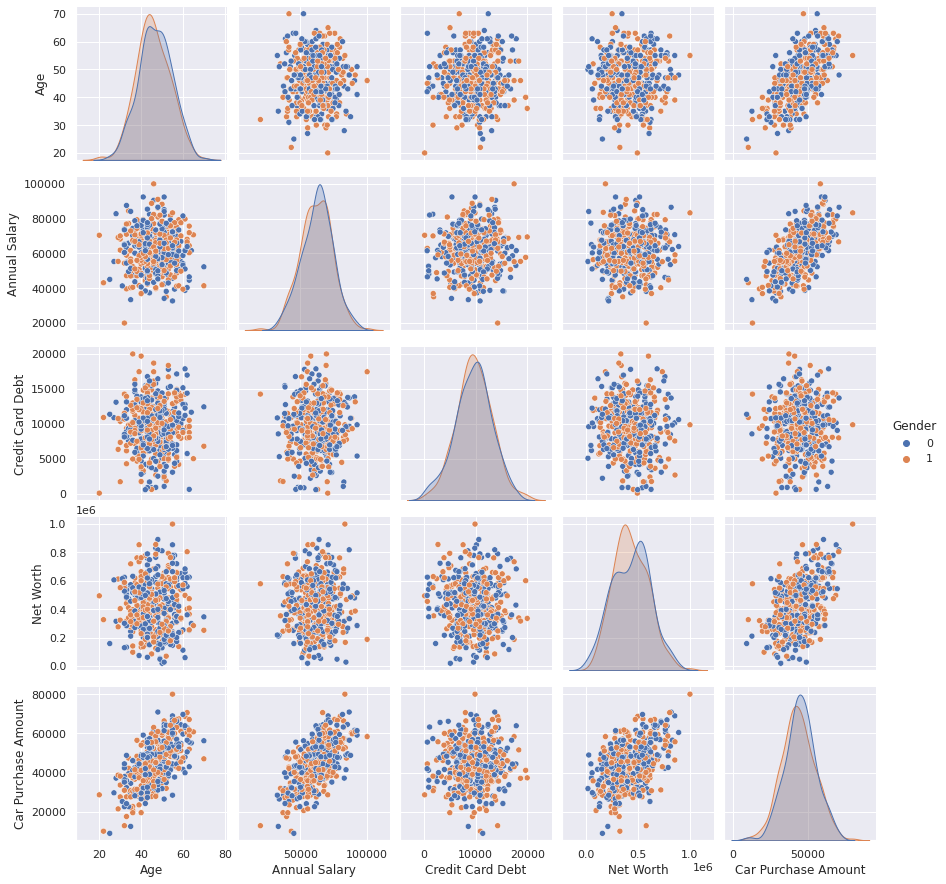

In [2]:
rawData = pd.read_csv("Car_Purchasing_Data.csv")
## Colour coding according to Gender
## 1 represents a Male
## 0 represents a Female
sns.pairplot(rawData,hue='Gender')

- From the above pairplot, we can see that the features have completely varying scales.
- This would consequently lead to our algorithm having an error graph which has a much greater curvature which makes it difficult for gradient descent to find the minima.
- The varying scales could also cause the gradient descent algorithm to oscillate and take radical steps in non-optimal directions, which ultimately could slow down convergence or even cause divergence.
- We can also see that every feature is almost linearly related to the target feature (last column of the plot), Car Purchase Amount which is indicative that Linear Regression should perform well.

# Linear Regression Implementation Class

## How to Use
 - To train a model call the fit method.<br>
 - The fit method takes in parameters such as the Features, Targets, Learning Rate, Threshold to measure the norm, Solver(gradient descent or closed form) and regularization value.<br>
 - Once a model is trained, call the predict method to test the model or make predictions against new inputs. <br>
 - All the other functions are private to the class and are called within the fit method. <br>
 - It will be similar to the sklearn Linear Regression model in terms of utilisation. <br>

In [3]:
class LinearRegression:

## The set coeffecients method will take in the datasets features and compose a coefficient matrix which will be used within Gradient Descent
    def __setCoeffecients(self, data):

        rows, cols = np.shape(data)
## We add an extra column to represent the bias 
        coeffecients = np.zeros((cols+1,1))
## We also add the entire column of ones to the dataset, to represent the bias as well
        newData = np.insert(data,0,1,axis=1)
        return coeffecients,newData

## Function that will calculate the cost given a set of coeffecients
    def __costFunction(self,theta,x,y):
        n = len(y)
        j = (1/(2*n))*np.sum(((np.subtract(np.dot(x,theta),y))**2))
        return j
## Function to return the hypothesis value/s
    def __hypothesis(self,theta,x):
        h = x @ theta
        return h

## Batch Gradient Descent
## If regularisation =0 , we have no regulararization and if it is not 0, then we use regularization
## We loop either until the difference in our theta values is < epsilon but return the number of epochs it took to reach the solution
    def __GradientDescent(self,data,targets,theta,learningRate,epsilon,regularisation):

        n = np.shape(data)[0]
        threshold = 10
        Costs_For_Each_Theta = []
         ## Updating weights with regularization
        i = 0
        if(regularisation != 0):
            while(threshold>epsilon):
                thetaOld = np.copy(theta)
                h = self.__hypothesis(thetaOld,data)
                ## Since we do not regularize on theta 0
                theta[0][0] = thetaOld[0][0] - (learningRate/n)*((data.T @ (h-targets))[0])
                ##Regularize remainder of theta values
                theta[1:,0] = thetaOld[1:,0]*(1-((learningRate*regularisation)/n)) - (learningRate/n)*((data.T @ (h-targets))[1:,0])
                ## Since we have updated the weight, we calculate the norm between the updated and old weights, and if it small enough, we break from the loop
                threshold = np.linalg.norm(thetaOld - theta)
                ## Adding the cost function value calculated using the new weights
                Costs_For_Each_Theta.append(self.__costFunction(thetaOld,data,targets))
                ## Keeping track of i as the number of epochs taken to train
                i+=1
        ## No regularization
        else:
            while(threshold>epsilon):
                thetaOld = np.copy(theta)
                h = self.__hypothesis(thetaOld,data)
                theta = thetaOld- (learningRate/n)*((data.T @ (h-targets)))
                threshold = np.linalg.norm(thetaOld - theta)
                Costs_For_Each_Theta.append(self.__costFunction(thetaOld,data,targets))
                i+=1

        return theta,Costs_For_Each_Theta,i


    def __closedFormSolution(self,x,y):
        return np.linalg.inv((x.T@x))@(x.T @ y)
    
    ## Call the fit method in order to train a model
    ## data: represents the features
    ## targets: the targets
    ## alpha: learning rate
    ## epsilon: the threshold to check the norm of the weight updates
    ## solver : either gd or closed-form
    ## regularisation: the lambda value. if 0, no regularisation
    def fit(self,data,targets,alpha,epsilon,solver,regularisation):

        coeff,data = self.__setCoeffecients(data)

        self.solver = solver
        self.regularisation = regularisation
        answers,costs = None,None
        numberOfEpochsTakenToTrain = None
        ## If the solver is gd we use gradient descent
        if(solver == "gd"):
            answers,costs,numberOfEpochsTakenToTrain = self.__GradientDescent(data,targets,coeff,alpha,epsilon,regularisation=regularisation)
        ## We use a closed form solution
        elif(solver == "closed-form"):
            answers = self.__closedFormSolution(data,targets)
        ## Stop the timer
        self.weights = answers
        ## Return the weights, cost values after each update and the number of epochs for training
        return answers,costs,numberOfEpochsTakenToTrain

    def __metrics(self,predicted,targets):
        mse = mean_squared_error(targets,predicted)
        rsquared = r2_score(targets,predicted)
        return mse,rsquared

    ## Call the predict method to predict answers using the trained model
    def predict(self,data,targets):
       ## if any of the weights are infinity, we have diverged and raise an error
        if(np.isnan(self.weights).any()):
            return ValueError(f"Weights contain Infinity,{self.solver} has diverged.")
        ## otherwise predict and show return the predictions as well as metrics showing the performance
        c,newData = self.__setCoeffecients(data)
        ## In order to make predictions, simply use the learnt weights multiplied by the test features
        predicted = self.__hypothesis(self.weights,newData)
        mse,r2 = self.__metrics(predicted,targets)
        return predicted,mse,r2


# Class for dealing with the data

#### Understanding the dataset

- We are trying to predict an amount that an individual will be able to spend when purchasing a new car.
- The features we use to predict are : 
  1. Gender: 1 represents a male and 0 a female.
  2. Age.
  3. Annual Salary.
  4. Credit Card Debt.
  5. Net Worth.
- We have a total of 500 data points.

- In the class we simply call the Load_and_Split_Data method<br>
- The method takes in parameters such as name which is the name of the file, headers which is a boolean saying if the columns names are present, test_size which is a float between 0 - 1 representing the percentage of the data that will be used for testing and the scale is a boolean representing whether or not to standardize the data. <br>
- We return the Training and Testing data

In [4]:
class Dataset:
    ## Method to split the data with test size using the built-in sklearn method for splitting
    def __SplitData(self, x,y,testSize):
        trainx,testx, trainy,testy = train_test_split(x,y,test_size=testSize,random_state=42)

        return trainx,trainy,testx,testy
    ## General method to standardize  features
    def __Standardize(self,x):
        rows,cols = np.shape(x)
        
        for i in range(cols):
            feature = x[:,i]
            mean = np.mean(feature)
            standard_deviation = np.std(feature)
            feature -= mean
            feature /= standard_deviation
            x[:,i] = feature
        
        return x
    ## We call this method which will call standardize on the features
    def __ScaleData(self,x):
        scaledx  = self.__Standardize(x)
        return scaledx
    ## This method is the interface for interacting with the class
    ## name: represents the name of the file we want to load
    ## headers: a boolean value stating whether or not the file contains headers
    ## test_size: the size we want our test data to be. a decimal between 0 and 1
    ## scale : a boolean value telling us whether or not we want to scale the features
    ## Returns: Training and testing features and targets
    def Load_and_Split_Data(self, name,headers,test_size,scale):
        data = None
        if(headers):
            data = pd.read_csv(name)
        else:
            data = pd.read_csv(name,header=None)
        ## Making sure we drop any missing values if they are present
        data = data.dropna()
        arrData = data.to_numpy()

        rows,cols = np.shape(arrData)
        x = arrData[:,:cols-1]
        y = arrData[:, -1]
        y = np.reshape(y,(np.shape(y)[0],1))
        if(scale):
            ## We only scale the features and not the targets
            x = self.__ScaleData(x)

        trainx,testx, trainy,testy = self.__SplitData(x,y,test_size)
        return trainx,testx, trainy,testy


# Method to call Linear Regression

- This method is used to call and perform linear regression iteratively with different learning rates. <br>
- We add the results into a table which we return and is eventually displayed.<br>
- Please note that the R <sup>2</sup> and mean squared error values in the table, are calculated with respect to the TEST dataset.

In [5]:
def doLinearRegression(TrainX,TrainY,TestX,TestY,regularisation):
    ## Creating a table to sumnmarise the results
    results = PrettyTable(["Learning Rate","Solver","Test MSE","Test R Squared Score","Epochs taken to Train"])
    model = LinearRegression()
    ## The varying learning rates we use
    alpha_vals = [0.5,0.4,0.3,0.2,0.1,0.01,0.001,0.0005,0.0003,0.0001]
    costs = []
    weights = []
    answers = []
    solvers = ["gd","closed-form"]
    learning_rates = []
                
    for learning_rate in alpha_vals:
        ## Calling Linear Regression for every alpha value
        for solver in solvers:
            ans,cost,epochsTaken = model.fit(data=TrainX,targets=TrainY,alpha=learning_rate,epsilon=0.0005,solver=solver,regularisation=regularisation)
            ans = None
            ## We check if the weights are not infinity and have diverged
            try:
                predVals , mse,r2 = model.predict(TestX,TestY)
            ## If we converge we predict using the learnt weights
            except:
                ans = model.predict(TestX,TestY)
        ## Use gradient descent
            if(solver != "closed-form"):
                if(ans == None):
                    results.add_row([learning_rate,solver,np.round(mse,5),np.round(r2,5),epochsTaken])
                    answers.append([predVals,solver])
                    costs.append(cost)
                    weights.append(ans)
                    learning_rates.append(learning_rate)
                else:
                    results.add_row([learning_rate,solver,ans,"N/A",epochsTaken])
                    costs.append(cost)
                    answers.append([ans,solver])
                    learning_rates.append(learning_rate)

            else:
                results.add_row(["N/A",solver,np.round(mse,5),np.round(r2,5),epochsTaken])
                answers.append([predVals,solver])
                solvers.pop()
                
    return results,costs,answers,learning_rates,weights


# Before Scaling Data Using Standardization

## Calling my Linear Regression Before Scaling Features

In [6]:
dataset = Dataset()
## Since the scale value is false,we use the unscaled raw data
TrainX,TrainY,TestX,TestY = dataset.Load_and_Split_Data(name = "Car_Purchasing_Data.csv",headers = True, test_size = 0.1, scale=False)
resultsBeforeScaling,costs,answers,learning_rates,weights = doLinearRegression(TrainX,TrainY,TestX,TestY,0)


## Plots of the Cost Function Before Scaling

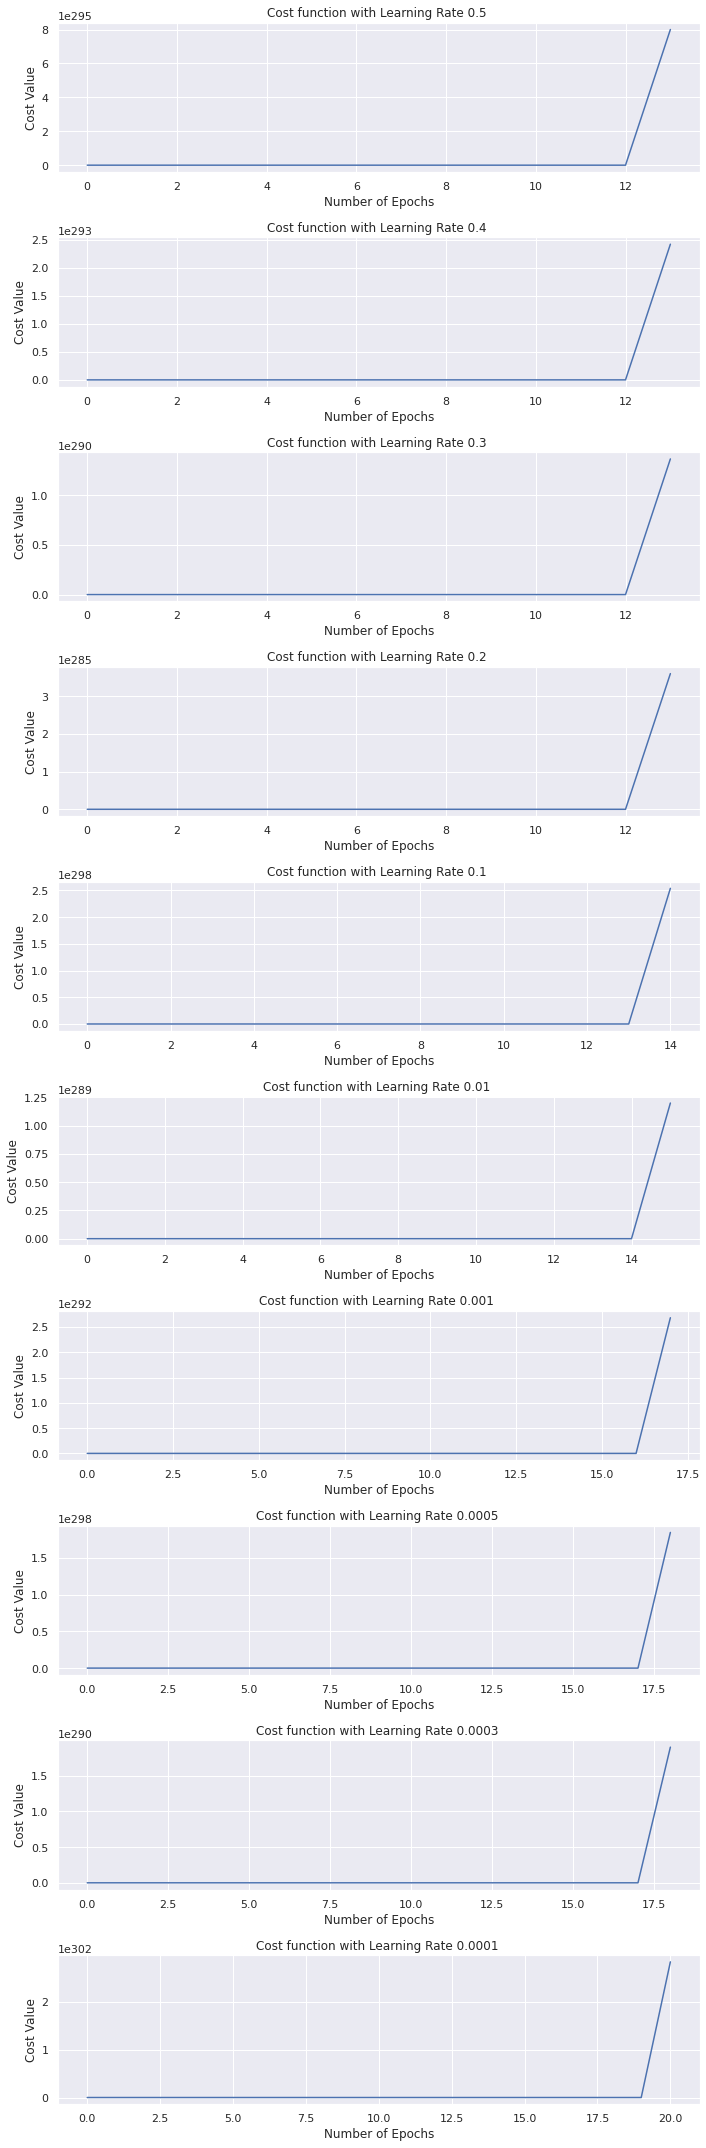

In [7]:
n = len(costs)
fig,ax = plt.subplots(nrows = n,ncols=1,figsize = (10,30))
for i in range(n):
    ax[i].plot(costs[i])
    ax[i].set_title(f'Cost function with Learning Rate {learning_rates[i]} ')
    ax[i].set_xlabel("Number of Epochs")
    ax[i].set_ylabel("Cost Value")

plt.tight_layout()

#### Discussing the above graphs

- From the above graphs , we can clearly see that irrespective of the learning rate, our cost function neither increases nor decreases for a while and then suddenly begins to increase.
- The increase in the cost function implies that our weights are incorrect and that we have diverged away from the solution.
- One of the causes of this divergence are the completely varying scales of the features. Since the scales are so different , our cost plane/function which we are trying to minimise, takes on a shape with more curvature like an ellipse. As a result, we may end up moving in an incorrect direction which causes our gradient to increase with each iteration and eventually diverge to infinity.
- We can also see that the bigger learning rates diverge faster (function increases at smaller number of epochs).
- If we consult the table below, the above sentiment is clearly shown.

## Summary Table of the Results Before Standardization

In [8]:
print(resultsBeforeScaling)

+---------------+-------------+-------------------------------------------+----------------------+-----------------------+
| Learning Rate |    Solver   |                  Test MSE                 | Test R Squared Score | Epochs taken to Train |
+---------------+-------------+-------------------------------------------+----------------------+-----------------------+
|      0.5      |      gd     | Weights contain Infinity,gd has diverged. |         N/A          |           29          |
|      N/A      | closed-form |                70263.00114                |       0.99931        |          None         |
|      0.4      |      gd     | Weights contain Infinity,gd has diverged. |         N/A          |           29          |
|      0.3      |      gd     | Weights contain Infinity,gd has diverged. |         N/A          |           30          |
|      0.2      |      gd     | Weights contain Infinity,gd has diverged. |         N/A          |           30          |
|      0.1      

- As we can see, I previously alluded to diverging cost functions. This is confirmed, since our weights all contained infinity values irrespective of the learning rates.
- Only the closed-form solution has converged to a solution.

# After Scaling Data Using Standardization

## Implementing Feature Scaling and Standardization

Please note that the standardization is implemented in the Dataset class. <br>
In order to activate it, we just need to make the scale paramter True.<br>

In [9]:
dataset = Dataset()
TrainX,TrainY,TestX,TestY = dataset.Load_and_Split_Data(name = "Car_Purchasing_Data.csv",headers = True, test_size = 0.1, scale=True)


## Calling my Linear Regression After Scaling and Standardization

In [10]:
resultsAfterScaling,costs,answers,learning_rates,weights = doLinearRegression(TrainX,TrainY,TestX,TestY,0)

## Summary Table of the Results After Standardization

In [11]:
print(resultsAfterScaling)

+---------------+-------------+-------------+----------------------+-----------------------+
| Learning Rate |    Solver   |   Test MSE  | Test R Squared Score | Epochs taken to Train |
+---------------+-------------+-------------+----------------------+-----------------------+
|      0.5      |      gd     | 70262.99155 |       0.99931        |           29          |
|      N/A      | closed-form | 70263.00114 |       0.99931        |          None         |
|      0.4      |      gd     | 70262.97794 |       0.99931        |           37          |
|      0.3      |      gd     | 70262.97298 |       0.99931        |           52          |
|      0.2      |      gd     | 70262.95256 |       0.99931        |           80          |
|      0.1      |      gd     | 70262.87526 |       0.99931        |          159          |
|      0.01     |      gd     | 70261.61448 |       0.99931        |          1408         |
|     0.001     |      gd     | 70249.39022 |       0.99931        |  

#### Discussion of Results Table

- From the table we can clearly see that since we standardized the features, we were able to converge to a solution.
- We can see that irrespective of our learning rates, we achieved an almost identical R<sup>2</sup> value, which describes a model which performed brilliantly.
- We can also see that as our learning rates decreased, our number of epochs  taken to train the model increased as well. This is coherent, since we are taking smaller steps in the direction of descent.
- For the extremely small learning rates such as 0.001,0.0001,0.0003,0.0005, we have extremely high number of epochs taken to train the model since the steps we are taking are extremely small. However, we still converged to the solution.
- We can also see that using the closed-form solution yielded the same result as using gradient descent.
- Lastly, we can see that mean squared error is quite large, however an extremely similar value is obtained utilising the scikit-learn model. As a result , our algorithm performs extremely well.

## Plots of the Cost Function After Scaling Features

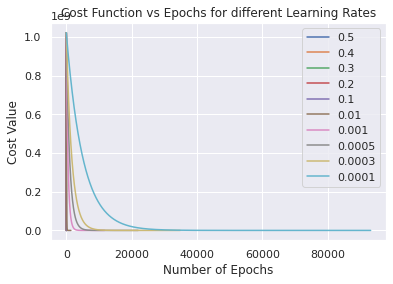

Each Cost Function Individually for better Viewing


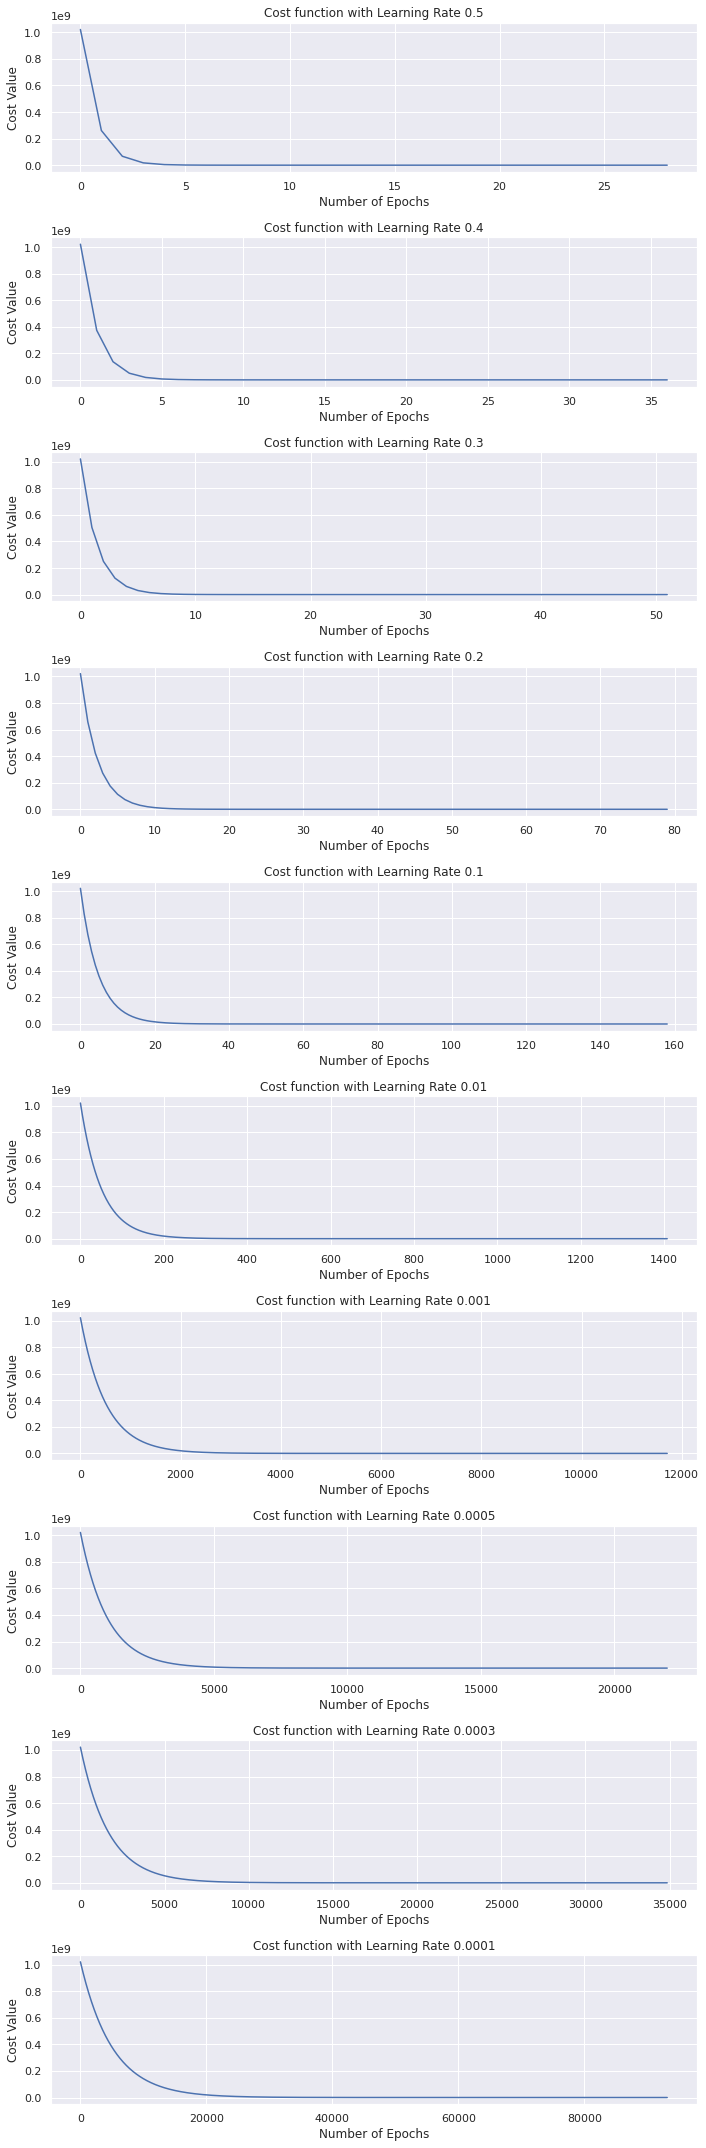

In [12]:
n = len(costs)
plt.xlabel("Number of Epochs")
plt.ylabel("Cost Value")
plt.title("Cost Function vs Epochs for different Learning Rates")
for i in range(n):
    plt.plot(costs[i],label = f"{learning_rates[i]}")
    
plt.legend()
plt.show()
print("Each Cost Function Individually for better Viewing")
fig,ax0 = plt.subplots(nrows = n,ncols=1,figsize = (10,30))
for i in range(n):
    ax0[i].plot(costs[i])
    ax0[i].set_title(f'Cost function with Learning Rate {learning_rates[i]}')
    ax0[i].set_xlabel("Number of Epochs")
    ax0[i].set_ylabel("Cost Value")

plt.tight_layout()

#### Discussing the Graphs

- We can clearly see that irrespective of our learning rates, each cost function does converge to a solution.
- However, we do observe that as we decreased the learning rate, our number of iterations/epochs (denoted on the x-axis) increases. This means we require more iterations to converge to a solution. i.e a slower convergence. This is expected since our step size is extremely small.

## Plots of Predicted Values vs Actual Values

Note that the plots below are : The values predicted for the test features and the actual test targets

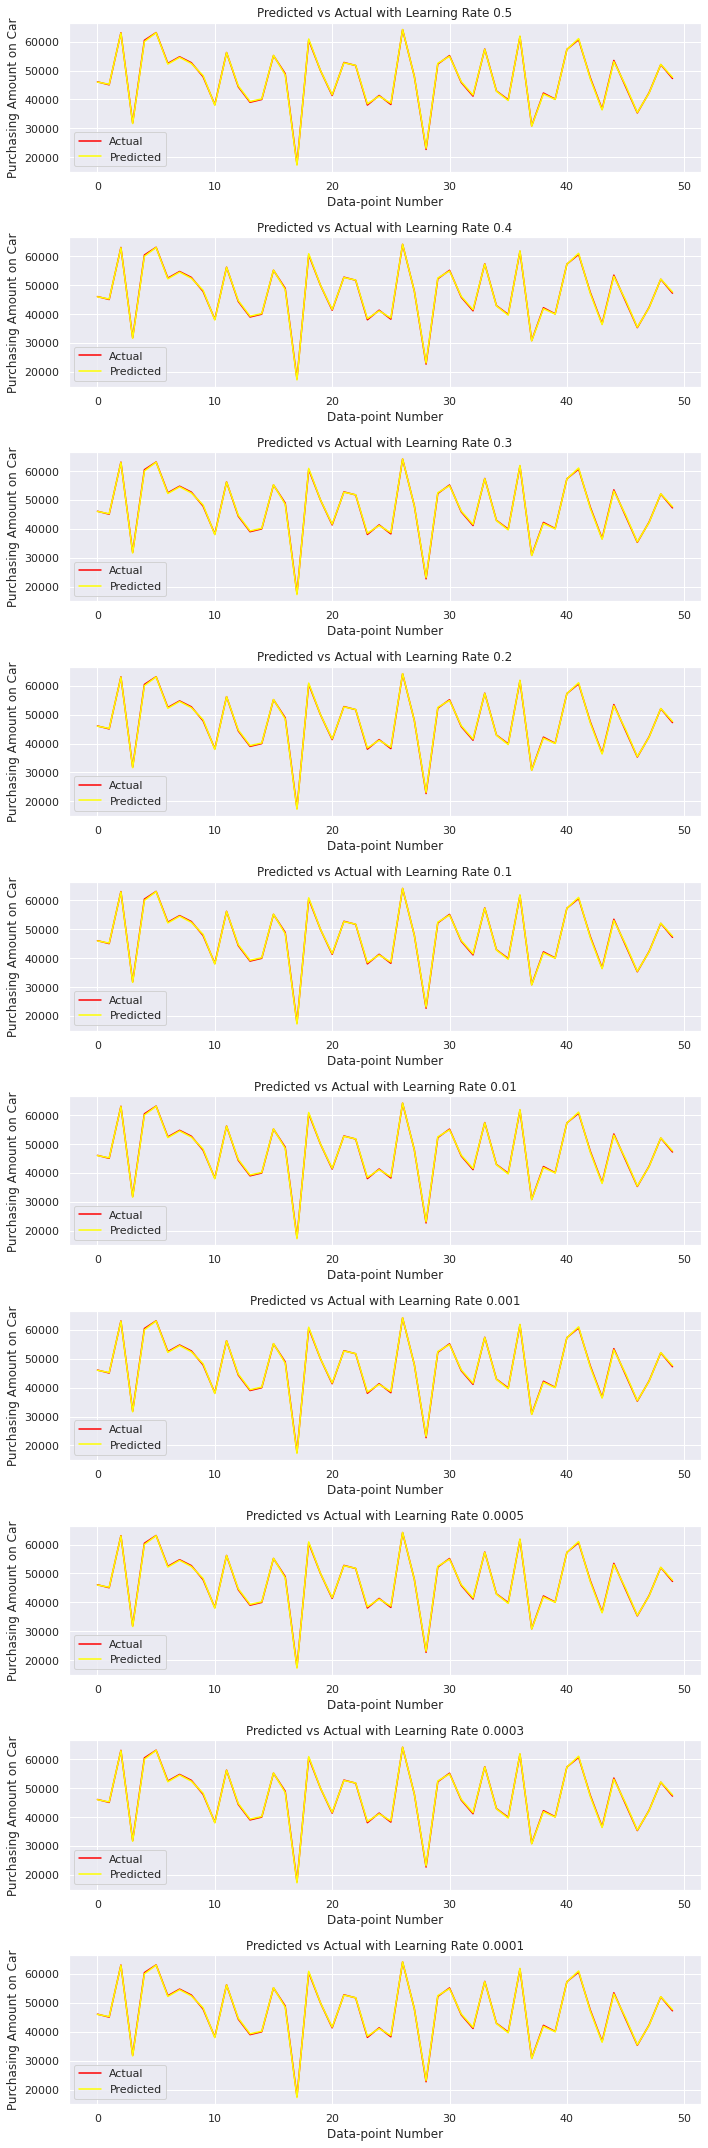

In [13]:
n = len(costs)

fig,ax1 = plt.subplots(nrows = n,ncols=1,figsize = (10,30))
for i in range(n):
    ax1[i].plot(TestY,color="red",label = "Actual")
    ax1[i].plot(answers[i][0],color = "yellow",label="Predicted")
    ax1[i].set_title(f'Predicted vs Actual with Learning Rate {learning_rates[i]}')
    ax1[i].set_xlabel("Data-point Number")
    ax1[i].set_ylabel("Purchasing Amount on Car")
    ax1[i].legend()
plt.tight_layout()

#### Dicussing the graphs

- There a 2 graphs, the actual test values (red) and the values predicted by the model (yellow).
- We can clearly see that the graphs are almost identical and on top of each other.
- This further iterates how well the model performs with an R<sup>2</sup> of 0.99.
- There are some points wherein the model varies, and we can see those where the actual graph protrudes slightly if we zoom in and points where the red is visible.

# After Scaling And Regularization

## Implementing Regularization

In [14]:
dataset = Dataset()
TrainX,TrainY,TestX,TestY = dataset.Load_and_Split_Data(name = "Car_Purchasing_Data.csv",headers = True, test_size = 0.1, scale=True)

## We simply apply each regularization value everytime we call doLinearRegression
regularization_vals = [1,50,150,250,350,500]
reg_costs = []
reg_predicted = []
for reg_val in regularization_vals:
    resultsAfterScalingAndRegularization,costs,answers,learning_rates,weights = doLinearRegression(TrainX,TrainY,TestX,TestY,regularisation=reg_val)
    reg_predicted.append(answers[0])
    reg_costs.append([costs,learning_rates])
    print(f'Results Using A regularization Value of {reg_val}\n')
    print(resultsAfterScalingAndRegularization)
    print('\n')


Results Using A regularization Value of 1

+---------------+-------------+-------------+----------------------+-----------------------+
| Learning Rate |    Solver   |   Test MSE  | Test R Squared Score | Epochs taken to Train |
+---------------+-------------+-------------+----------------------+-----------------------+
|      0.5      |      gd     | 70804.18386 |       0.99931        |           29          |
|      N/A      | closed-form | 70263.00114 |       0.99931        |          None         |
|      0.4      |      gd     | 70804.18343 |       0.99931        |           37          |
|      0.3      |      gd     |  70804.184  |       0.99931        |           52          |
|      0.2      |      gd     | 70804.18457 |       0.99931        |           79          |
|      0.1      |      gd     | 70804.18674 |       0.99931        |          159          |
|      0.01     |      gd     | 70804.24459 |       0.99931        |          1407         |
|     0.001     |      gd  

#### Disussing Results Table

- We can clearly see that as we increase the our regularisation value, our R<sup>2</sup> value begins to decrease which implies our model tends to perform worst.
- The mean squared error also increases which further indicates that we are tending towards underfitting the data.
- This is simply because, as we increase regularisation, we constrain and penalise our weights, making them smaller and this leads to incorrect predictions.
- Eventually if we make the regularisation values so large, we minimise the weights too much and end up with a model which has a high bias that underfits the data and consequently performs poorly.
- Thus my model did not require any regularisation, since we did not overfit the data in any way. Thus regularisation proved to be harmful in this scenario.

## Plots of Predicted vs Actual Values for Regularised Models

Note I only plot the predicted vs Actual values for the learning rate 0.5 since the models with other learning rates perform the same 

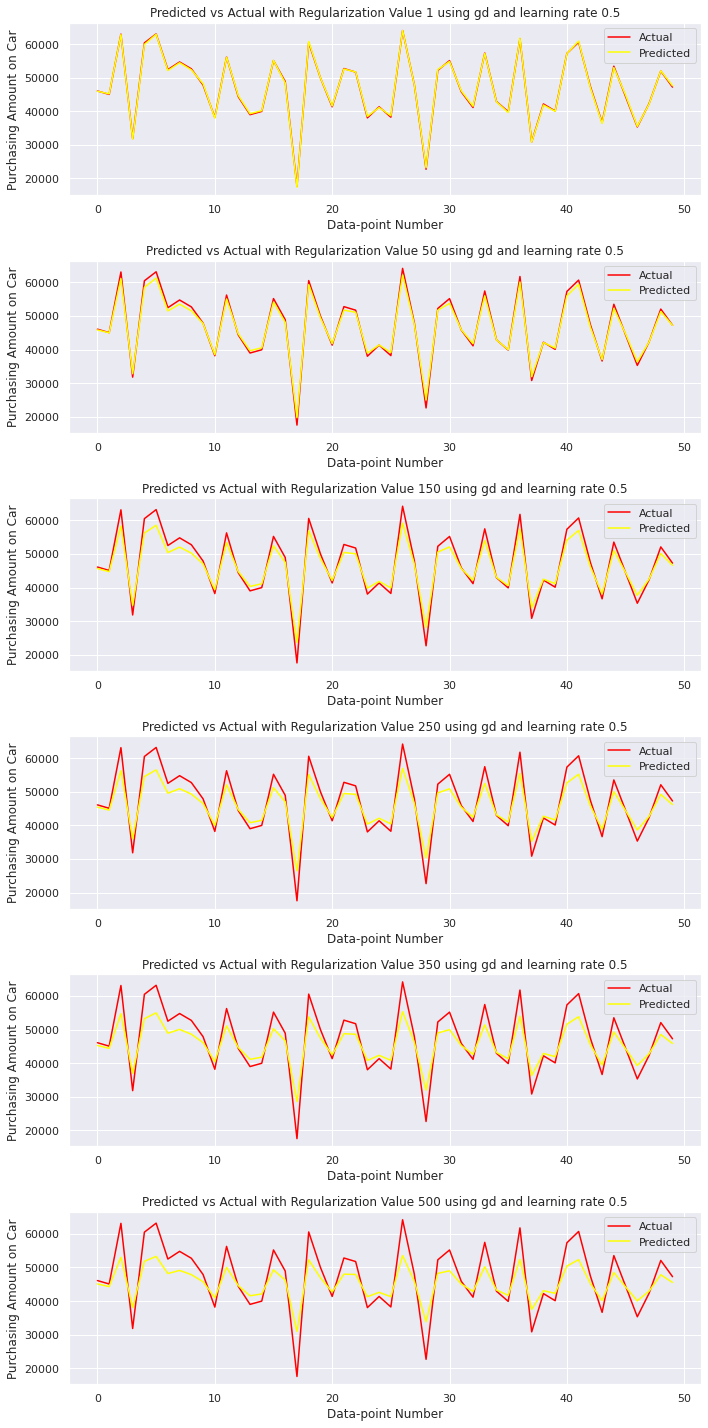

In [15]:
n = len(reg_predicted)
fig2,ax2 = plt.subplots(nrows = n,ncols=1,figsize = (10,20))
for i in range(n):
    ax2[i].plot(TestY,color="red",label = "Actual")
    ax2[i].plot(reg_predicted[i][0],color = "yellow",label="Predicted")
    solver = "gd"
    ax2[i].set_title(f'Predicted vs Actual with Regularization Value {regularization_vals[i]} using {solver} and learning rate 0.5')
    ax2[i].set_xlabel("Data-point Number")
    ax2[i].set_ylabel("Purchasing Amount on Car")
    ax2[i].legend()
plt.tight_layout()

#### Discussing the Plots

- We can clearly see that are the regularisation value increases, we penalize our weights too much which leads to an underfitting model.
- Since our model underfits the data, we have high bias and as a result our models predicted values vary greatly with respect to the actual values/targets.
- The only model which performs similar to the model without regularization, has a regularisation value of 1, which is extemely small and almost irrelevant.
- Thus the model does not require regularisation.

# Using Scikit-Learn Linear Regression for Comparison

In [16]:
from sklearn.linear_model import LinearRegression as SKLinear

In [17]:
LR = SKLinear()

LR.fit(TrainX,TrainY)

pred = LR.predict(TestX)

skmse = mean_squared_error(TestY,pred)
skr2 = r2_score(TestY,pred)

In [18]:
print(f"The Mean Squared Error is : {skmse}\n ")
print(f"The R^2 score is : {skr2}\n ")

The Mean Squared Error is : 70263.0011382625
 
The R^2 score is : 0.9993138079955485
 


### Results

- We can clearly see that the R <sup>2</sup> score and the mean squared error, for the scikit-learn model and my model are almost identical.
- Hence we can conclude that my model is optimal in learning the fit of the data and predicting on it.
- Below is the plot of predicted vs actual values for the test dataset of the scikit-learn results. The plot is identical to mine.

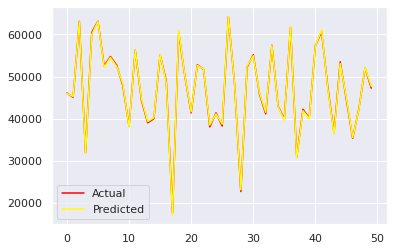

In [19]:
plt.plot(TestY,label = "Actual",color="red")
plt.plot(pred,label = "Predicted",color="yellow")
plt.legend()
plt.show()